In [1]:
import numpy
import numpy as np
import pandas as pd
import time
import datetime
import os,sys,glob
import json
import copy
import pickle


import warnings
warnings.filterwarnings('ignore')


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd


import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
import matplotlib.colors as mcolors
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['lines.linewidth'] = 3


import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)

In [2]:
def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)"] #, "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

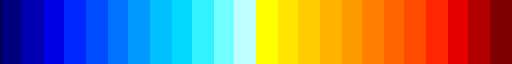

In [3]:
cmnew

In [4]:
'''
STAION ME PLOTS

'''

def investigate_station(path, year):
    if not isinstance(path, list):
        path = [path]
    diffs = {}
    difflist = []
    diffs_ud = {}
    difflist_ud = []
    diffs_di = {}
    difflist_di = []
    dict_base ={}
    dict_disp ={}
    dict_obs ={}
    
    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
    diff = True
    show_date = False
    for fi  in list(path):
        with open(fi, 'rb') as file:
            results = pickle.load(file)
        for i in results[:]:


            rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde, rmse_sum_shdisp_adjsonde, \
                rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde, rms_sum_shdisp, rms_sum_dispminusbase, stat_marker \
                = copy.deepcopy(i)

            if (len(stat_marker[50000]) == 0):
                continue

            for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
                rmse_sum_shbase_sonde[k]  = np.array(rmse_sum_shbase_sonde[k])
                rmse_sum_shbase_adjsonde[k]  = np.array(rmse_sum_shbase_adjsonde[k])
                rmse_sum_shdisp_sonde[k]  = np.array(rmse_sum_shdisp_sonde[k])
                rmse_sum_shdisp_adjsonde[k]  = np.array(rmse_sum_shdisp_adjsonde[k])
                rms_sum_shbase[k]  = np.array(rms_sum_shbase[k])
                rms_sum_adjsonde[k]  = np.array(rms_sum_adjsonde[k])
                rms_sum_sonde[k]  = np.array(rms_sum_sonde[k])
                rms_sum_shdisp[k]  = np.array(rms_sum_shdisp[k])
                rms_sum_dispminusbase[k]  = np.array(rms_sum_dispminusbase[k])

            t0 = time.time()
            rmse_shbase_sonde=[]
            rmse_shdisp_sonde=[]
            rmse_sum_shbase=[]
            rmse_sum_shdisp=[]
            rmse_sum_sonde=[]
            
            for j in range(len(stdplevs)):

                rmse_shbase_sonde.append(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[j]]))))
                rmse_shdisp_sonde.append(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[j]]))))
                rmse_sum_shbase.append(np.nanmean((np.array(rms_sum_shbase[stdplevs[j]]))))
                rmse_sum_shdisp.append(np.nanmean((np.array(rms_sum_shdisp[stdplevs[j]]))))
                rmse_sum_sonde.append(np.nanmean((np.array(rms_sum_sonde[stdplevs[j]]))))

            diffs[str(stat_marker[50000][0])] = np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde)
            difflist.append(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde))
            diffs_di[str(stat_marker[50000][0])] = np.array(rmse_shdisp_sonde)
            difflist_di.append(np.array(rmse_shdisp_sonde))
            diffs_ud[str(stat_marker[50000][0])] = np.array(rmse_shbase_sonde)
            difflist_ud.append(np.array(rmse_shbase_sonde))
            dict_base[str(stat_marker[50000][0])] = np.array(rmse_sum_shbase)
            dict_disp[str(stat_marker[50000][0])] = np.array(rmse_sum_shdisp)
            dict_obs[str(stat_marker[50000][0])] = np.array(rmse_sum_sonde)

    return diffs, difflist, diffs_ud, difflist_ud, diffs_di, difflist_di, dict_base, dict_disp, dict_obs

In [5]:
i_diffs, i_difflist, i_diffs_ud, i_difflist_ud, i_diffs_di, i_difflist_di, i_dbase, i_ddisp , i_dobs= {},{},{},{},{},{},{},{},{}
var = 'U'
year = '1991-2000'
files = glob.glob('./pre_calculated_rms data/era5_u_fc_*_rmse_data.p')
for i in files:
    print(i)
    i_diffs[i], i_difflist[i], i_diffs_ud[i], i_difflist_ud[i], i_diffs_di[i], i_difflist_di[i], i_dbase[i], i_ddisp[i], i_dobs[i] = investigate_station(i, str(year))

./pre_calculated_rms data/era5_u_fc_2000_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1996_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1995_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1994_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1993_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1992_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1991_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1997_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1999_rmse_data.p
./pre_calculated_rms data/era5_u_fc_1998_rmse_data.p


In [6]:
diffs, difflist, diffs_ud, difflist_ud, diffs_di, difflist_di, dbase, ddisp, dobs= {},{},{},{},{},{},{},{},{}

for j in i_diffs[list(i_diffs.keys())[0]]:
    # print(j)
    diffs_dummy = []
    diffs_ud_dummy = []
    diffs_di_dummy = []
    dbase_dummy = []
    ddisp_dummy = []
    dobs_dummy = []
    
    badcounter = 0
    for i in i_diffs:
        try:
            diffs_dummy.append(list(i_diffs[i][j]))
            diffs_ud_dummy.append(list(i_diffs_ud[i][j]))
            diffs_di_dummy.append(list(i_diffs_di[i][j]))
            dbase_dummy.append(list(i_dbase[i][j]))
            ddisp_dummy.append(list(i_ddisp[i][j]))
            dobs_dummy.append(list(i_dobs[i][j]))
            # print('___',i)
        except:
            # print('xxx', i)
            badcounter += 1
        # print(badcounter)
    if badcounter < 6:
        diffs[j] = np.nanmean(diffs_dummy, axis = 0)
        diffs_ud[j] = np.nanmean(diffs_ud_dummy, axis = 0)
        diffs_di[j] = np.nanmean(diffs_di_dummy, axis = 0)
        dbase[j] = np.nanmean(dbase_dummy, axis = 0)
        ddisp[j] = np.nanmean(ddisp_dummy, axis = 0)
        dobs[j] = np.nanmean(dobs_dummy, axis = 0)


In [7]:
with open('/users/staff/uvoggenberger/scratch/hug/config/active.json') as fp:
    active = json.load(fp)
stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
diff_plot_input = {}
for p in range(len(stdplevs)):
    diff_plot_input[stdplevs[p]] = [[],[],[], [], [], [], []]
    for i in diffs:
        for a in active:
            if i in a:
                if not np.isnan(diffs[i][p]):
                    diff_plot_input[stdplevs[p]][0].append(diffs[i][p])
                    diff_plot_input[stdplevs[p]][1].append(active[a][2])
                    diff_plot_input[stdplevs[p]][2].append(active[a][3])
                    diff_plot_input[stdplevs[p]][3].append(i)
                    diff_plot_input[stdplevs[p]][4].append(dbase[i][p])
                    diff_plot_input[stdplevs[p]][5].append(ddisp[i][p])
                    diff_plot_input[stdplevs[p]][6].append(dobs[i][p])
                break

In [14]:
i = 20000
df = pd.DataFrame(np.transpose(np.array(diff_plot_input[i])), columns =['diff', 'latitude', 'longitude', 'stat', 'basev', 'dispv', 'obsv'])
df['diff'][df['diff'] == 'nan'] = np.nan
df['diff'] = pd.to_numeric(df['diff'])
df

,diff,latitude,longitude,stat,basev,dispv,obsv
0,-0.075845,33.17890167236328,-86.7822036743164,72230,24.525927005837435,24.601772144556726,25.25271027562576
1,0.018807,6.949999809265137,158.1999969482422,91348,-2.9546589321178063,-2.973466286522508,-2.9755636328214368
2,-0.171675,-32.84375,-68.79631042480469,87418,27.40384562920515,27.575520773165966,27.43237025699551
3,0.011002,13.479999542236328,2.1700000762939453,61052,7.525607775507786,7.514605872135254,7.074125751602203
4,-0.079910,23.766700744628906,90.38330078125,41923,9.062242414643043,9.142152603592587,8.529870461316886
...,...,...,...,...,...,...,...
668,0.040315,-27.61829948425293,-144.33470153808594,91958,27.86394847463127,27.823633056891225,27.405517644432802
669,-0.382826,41.56999969482422,108.5199966430664,53336,34.23517520721051,34.618001088977145,35.06768092785066
670,-0.069477,23.350000381469727,116.66999816894531,59316,18.089067727418357,18.158544672112907,18.634554334864227
671,0.062594,15.600000381469727,32.54999923706055,62721,6.1063674367865755,6.043773105182785,7.107458875480304


In [15]:
# colorm = np.full(len(np.array(df['diff'])), 'green')
# colorm[np.greater(df['diff'], 0.2, where=~np.isnan(df['diff']))] = 'red'
# colorm[np.less(df['diff'], -0.2, where=~np.isnan(df['diff']))] = 'blue'
# df['colorm'] = colorm

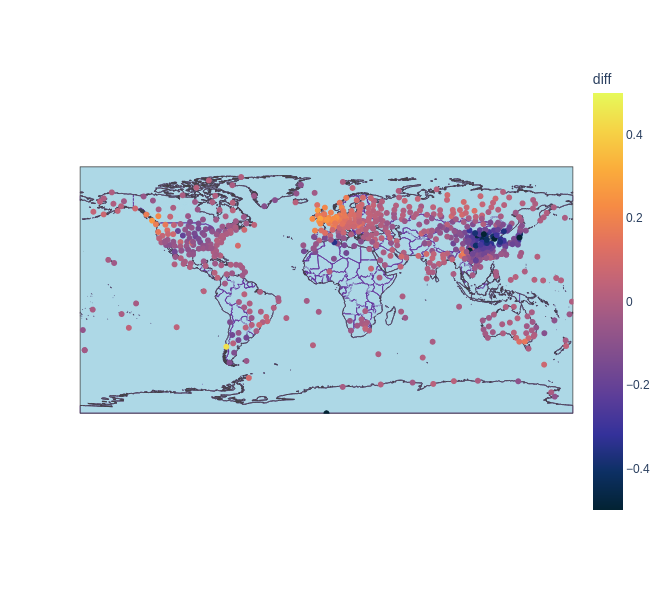

In [16]:
fig = px.scatter_geo(df, lat='latitude', lon='longitude', color='diff',color_continuous_scale='thermal',range_color=(-0.5,0.5), hover_name='stat', width= 1000, height=600, )
fig.update_geos(
    resolution=50,
    showcountries=True, countrycolor="RebeccaPurple",
    showland=True, landcolor="LightBlue",
    showocean=True, oceancolor="LightBlue",
    showlakes=True, lakecolor="LightBlue",
    showrivers=True, rivercolor="LightBlue"
)
fig.show()

In [17]:
def plot_stat_mean_asc(stat, diffs, dbase, ddisp, dobs):
    fig, ax = maplt.subplots(1, 1, figsize = (15,10))
    #     fig, ax1 = maplt.subplots(1, 1, figsize = (15,10))
    ax.plot(np.array(dobs),stdplevs,color='black', label='Observation')
    # ax.plot(np.array(diffs),stdplevs,color='orange', label='Difference')
    ax.plot(np.array(dbase),stdplevs, color='blue', label='Undisplaced')
    ax.plot(np.array(ddisp),stdplevs, color='red', label='Displaced')
    ax.set_title(stat)
    ax.legend(loc='upper right')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_ylabel('pressure (Pa)')
    ax.set_xlabel(var)
    ax.legend(loc='lower right')
    ax.grid()
    maplt.show()
    maplt.close()

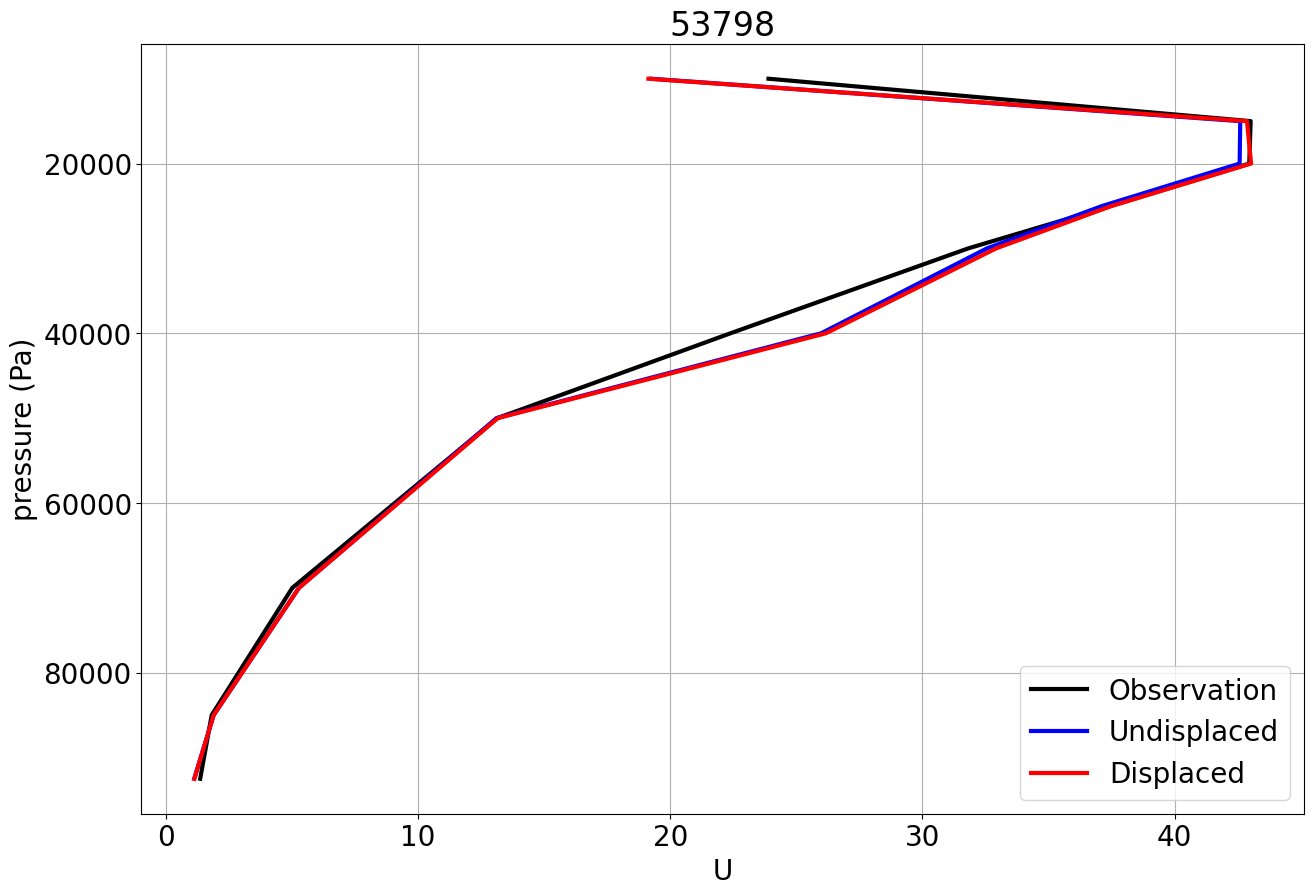

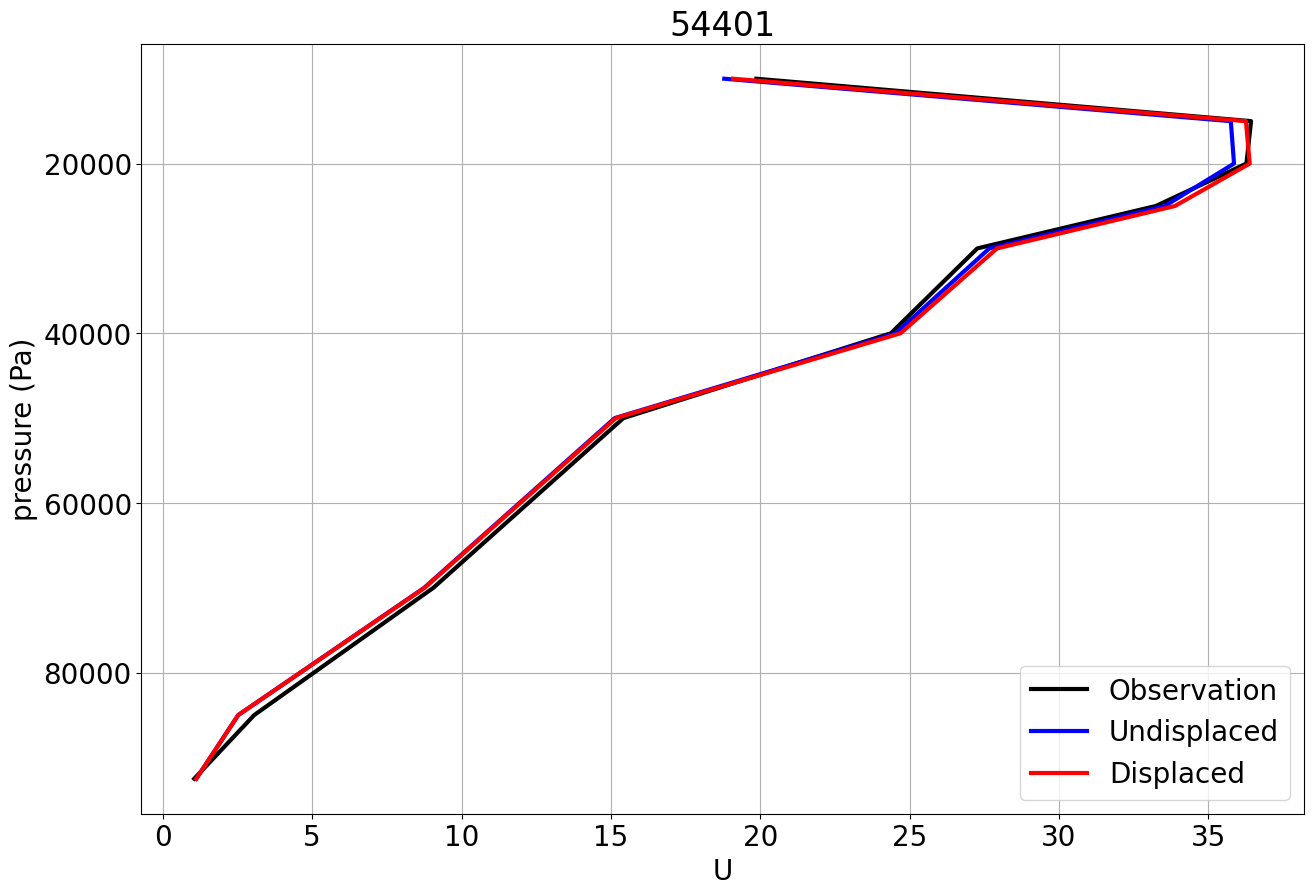

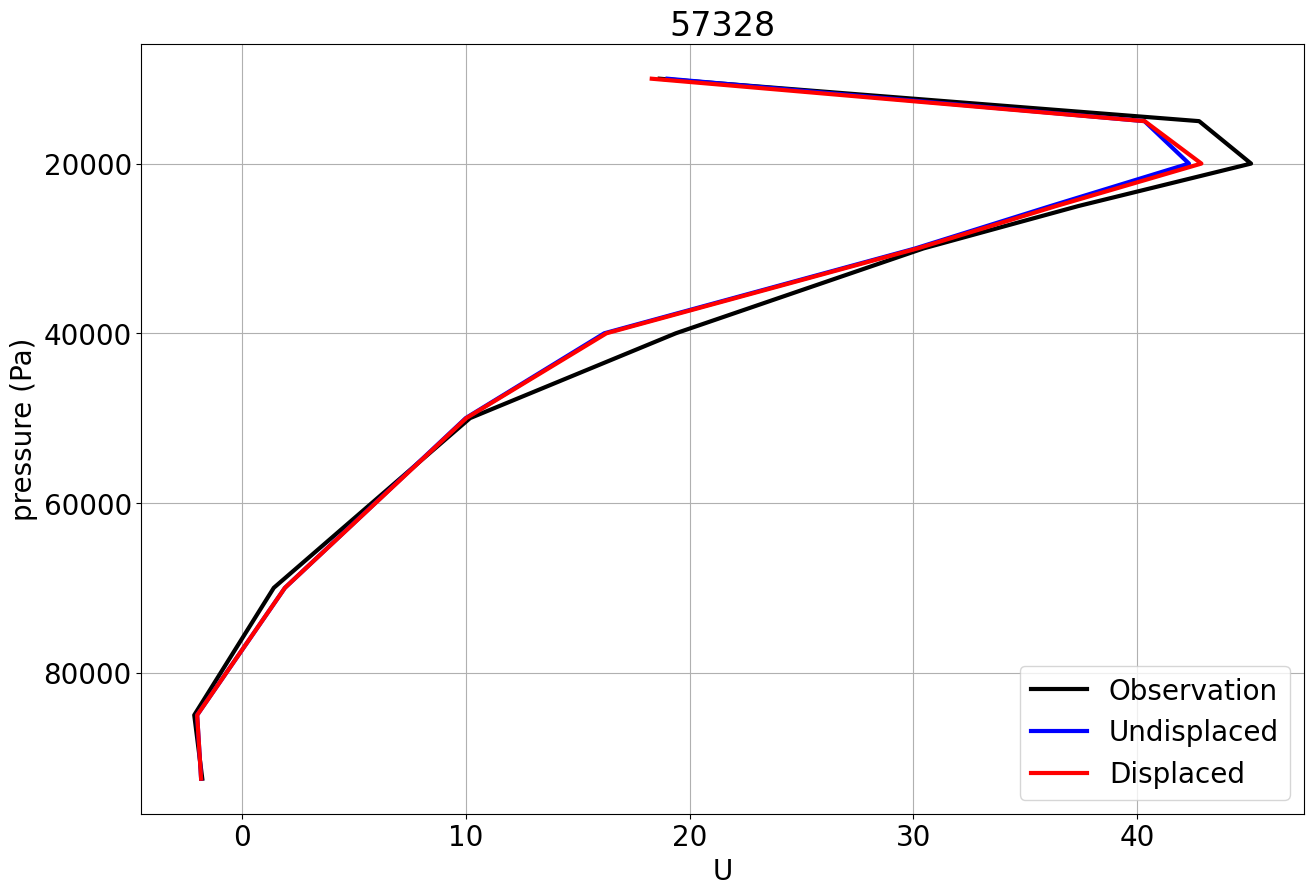

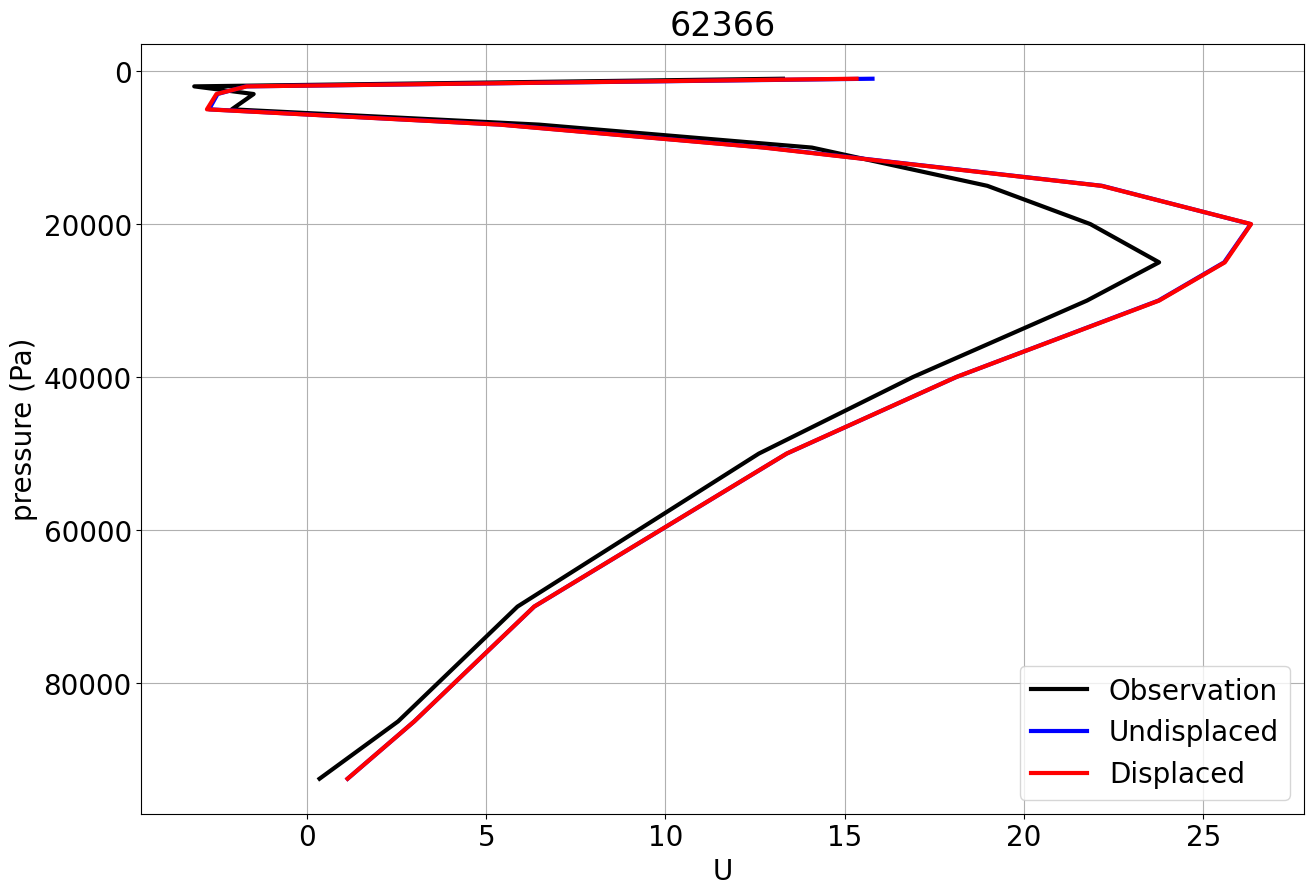

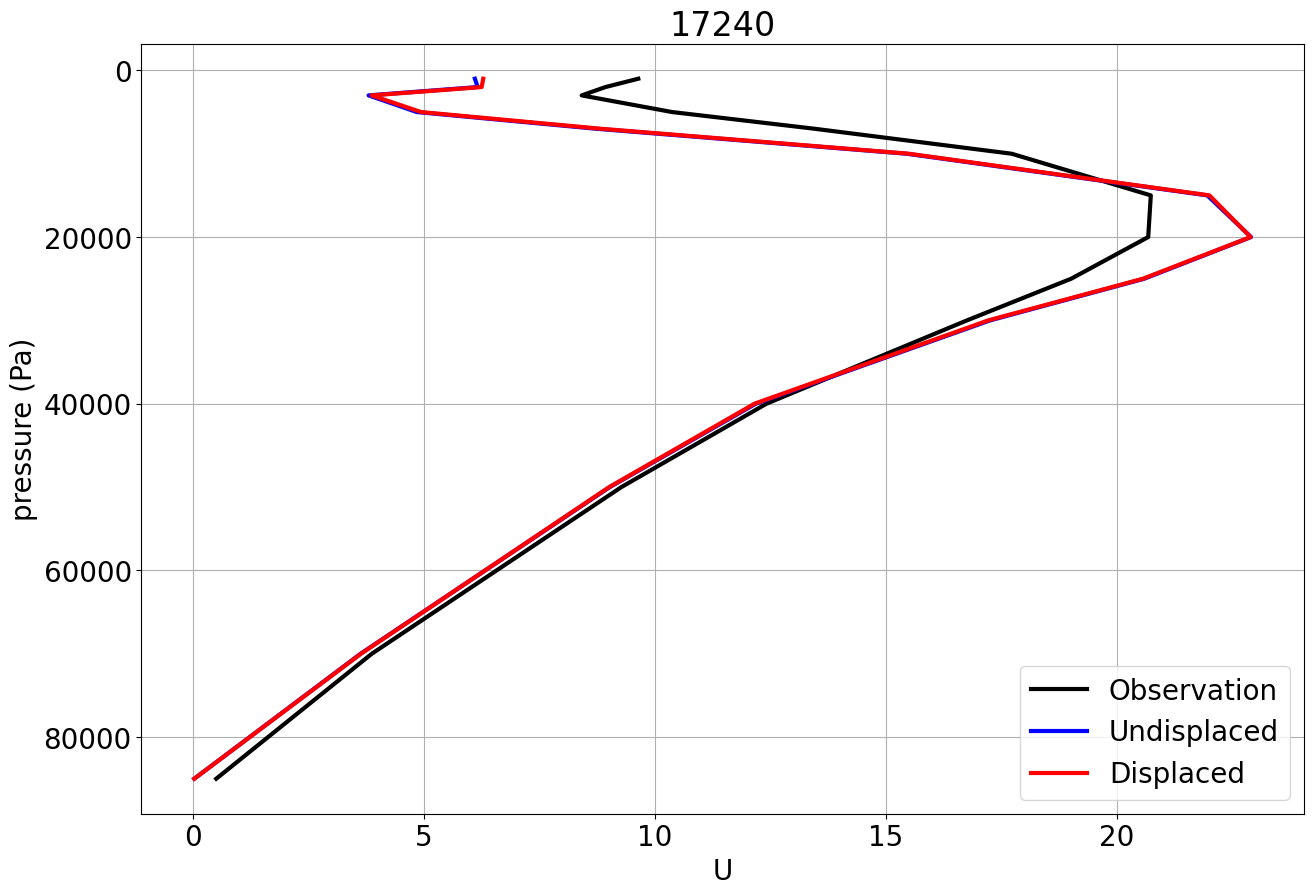

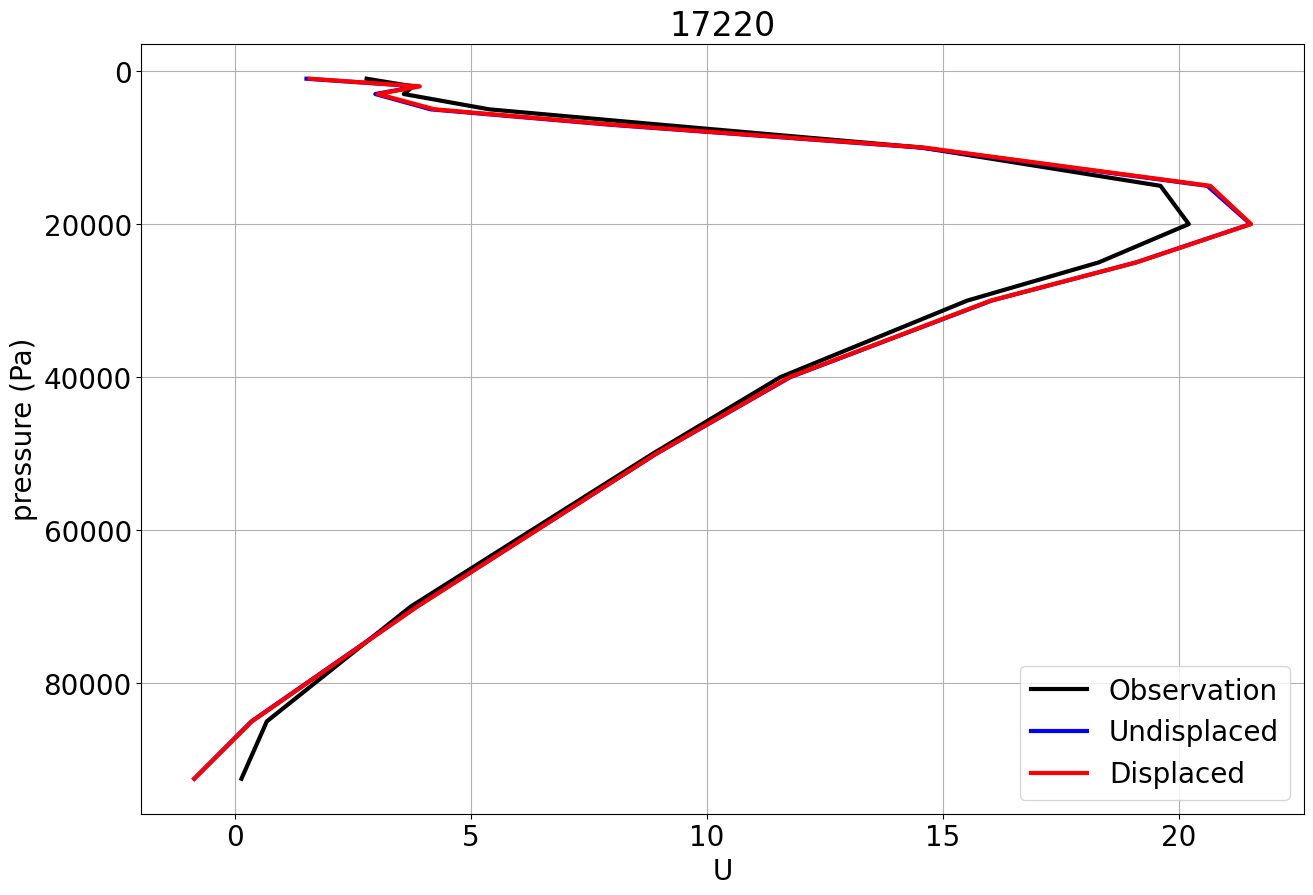

In [18]:
for stat in ['53798', '54401', '57328', '62366', '17240', '17220']:
    plot_stat_mean_asc(stat, diffs[stat], dbase[stat], ddisp[stat], dobs[stat])

# DIFFERENCE

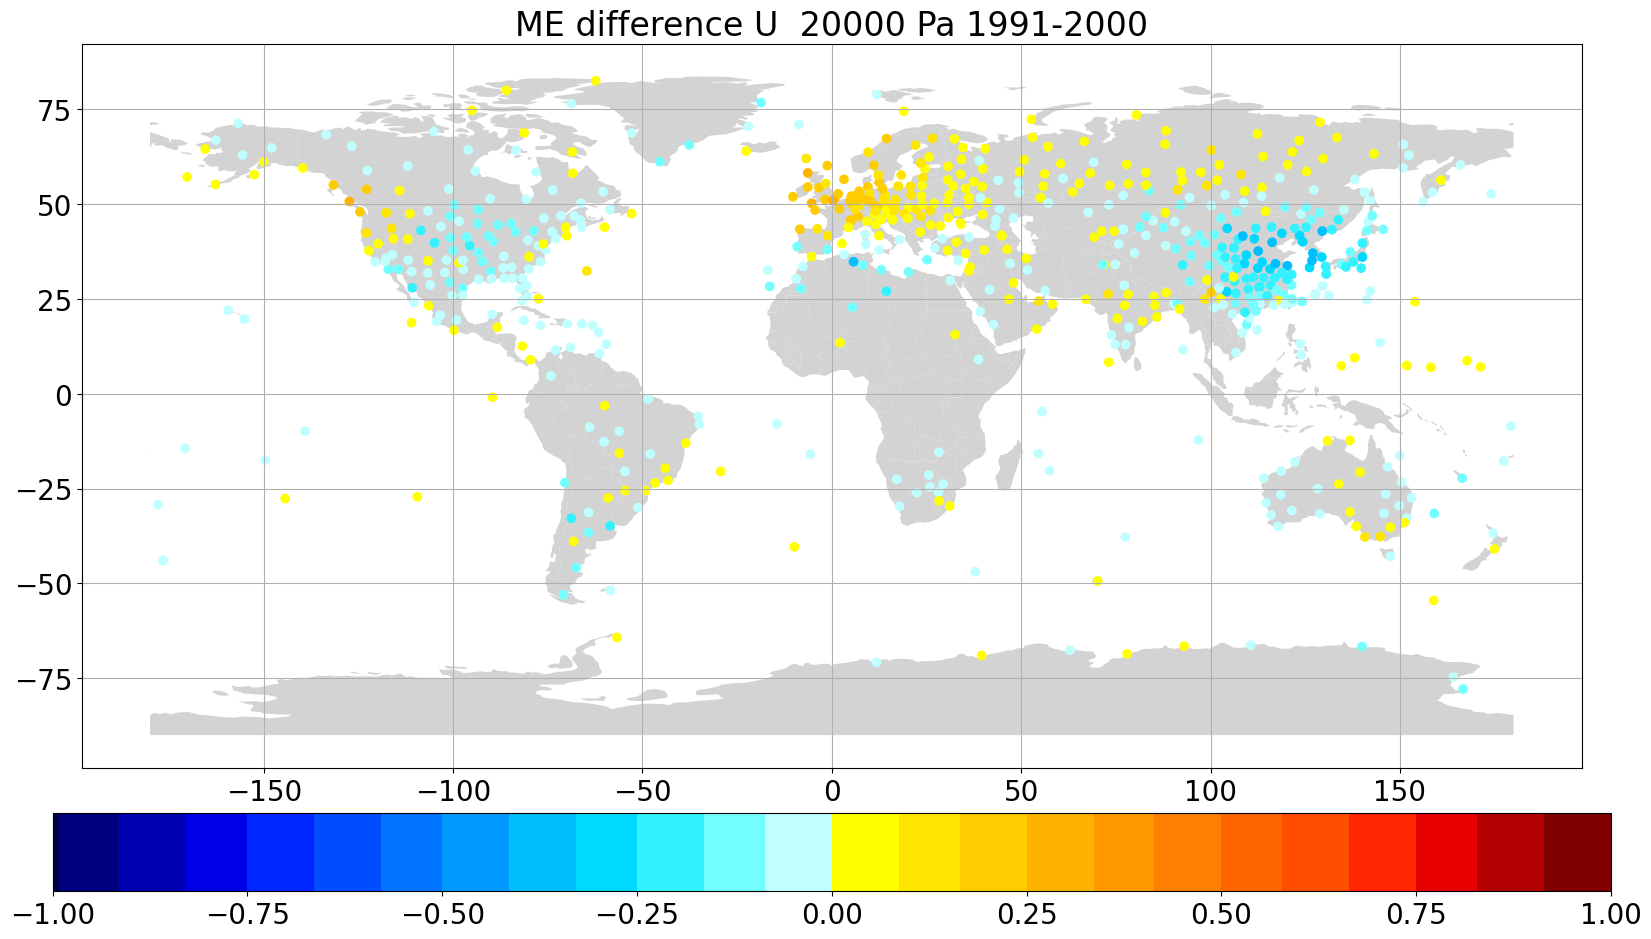

In [19]:
var = 'U'
year = '1991-2000'
files = glob.glob('./pre_calculated_rms data/era5_u_fc_*_rmse_data.p')
# diffs, difflist = plot_year_me(files, str(year), param='diff')


diffarray = np.array(i_difflist['./pre_calculated_rms data/era5_u_fc_1991_rmse_data.p'])

# outlier_cleaned_data = np.empty_like(diffarray)
outlier_cleaned_dict = copy.deepcopy(diffs)
limit = [1,99]
for i in range(np.shape(diffarray)[-1]):
    data = diffarray[:, i]
    outlier_drop = np.nanpercentile(data, limit)
    data[data < outlier_drop[0]] = np.nan
    data[data > outlier_drop[1]] = np.nan
    # outlier_cleaned_data[:, i] = data
    
    for j in diffs:
        if (diffs[j][i] < outlier_drop[0]) or (diffs[j][i] > outlier_drop[1]):
            outlier_cleaned_dict[j][i] = np.nan
            
    
# stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
# fig, ax = maplt.subplots(5, 3, figsize = (15,15))
# fig.tight_layout()
# x = 0
# y = 0
# for i in range(0,15,1):
#     if y == 3:
#         x += 1
#         y = 0
#     ax[x][y].hist(outlier_cleaned_data[:, i], 50, range=(-1,1))
#     ax[x][y].set_title(str(stdplevs[i]) + ' Pa')
#     ax[x][y].grid()
    
#     y += 1
# # fig.show()
# fig.savefig("ME_difference_"+var+"_hist_" + str(year) + '.png')


# stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
# fig, ax = maplt.subplots(5, 3, figsize = (15,15))
# fig.tight_layout()
# x = 0
# y = 0
# for i in range(0,15,1):
#     if y == 3:
#         x += 1
#         y = 0
#     ax[x][y].hist(outlier_cleaned_data[:, i], 2, range=(-1,1))
#     ax[x][y].set_title(str(stdplevs[i]) + ' Pa')
#     ax[x][y].grid()
#     y += 1
# # fig.show()
# fig.savefig("ME_difference_"+var+"_binary_hist_" + str(year) + '.png')


def plt_world_map(lla, pl ,year):    
    fig, ax = plt.subplots(figsize=(18,10))# plot map on axis
    countries = gpd.read_file(  
    #      gpd.datasets.get_path("naturalearth_lowres"))countries[countries["name"] == "Australia"].plot(color="lightgrey",
    #                                                  ax=ax)# parse dates for plot's title
        gpd.datasets.get_path("naturalearth_lowres")).plot(color="lightgrey", ax=ax)# parse dates for plot's title
    plt1 = ax.scatter(x=lla["longitude"], y=lla["latitude"],
                c=lla["diff"], 
                cmap= cmnew,
                vmin=-1, vmax=1, #edgecolor='k',
              )
    ax.set_title("ME difference "+var+" " + ' ' + str(pl) + ' Pa ' + str(year))
    ax.grid(b=True, alpha=1)
    plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.show()
    fig.savefig("ME_difference_"+var+"_" + str(pl) + '_Pa_' + str(year) + '.png')
    plt.close()
    
with open('/users/staff/uvoggenberger/scratch/hug/config/active.json') as fp:
    active = json.load(fp)
stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
diff_plot_input = {}
for p in range(len(stdplevs)):
    diff_plot_input[stdplevs[p]] = [[],[],[]]
    for i in diffs:
        for a in active:
            if i in a:
                if not np.isnan(diffs[i][p]):
                    diff_plot_input[stdplevs[p]][0].append(outlier_cleaned_dict[i][p])
                    diff_plot_input[stdplevs[p]][1].append(active[a][2])
                    diff_plot_input[stdplevs[p]][2].append(active[a][3])
                break

stdplevs = [20000]#[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
for i in np.flip(stdplevs):
    df = pd.DataFrame(np.transpose(np.array(diff_plot_input[i])), columns =['diff', 'latitude', 'longitude'])
    plt_world_map(df, i, year)

# DISPLACED

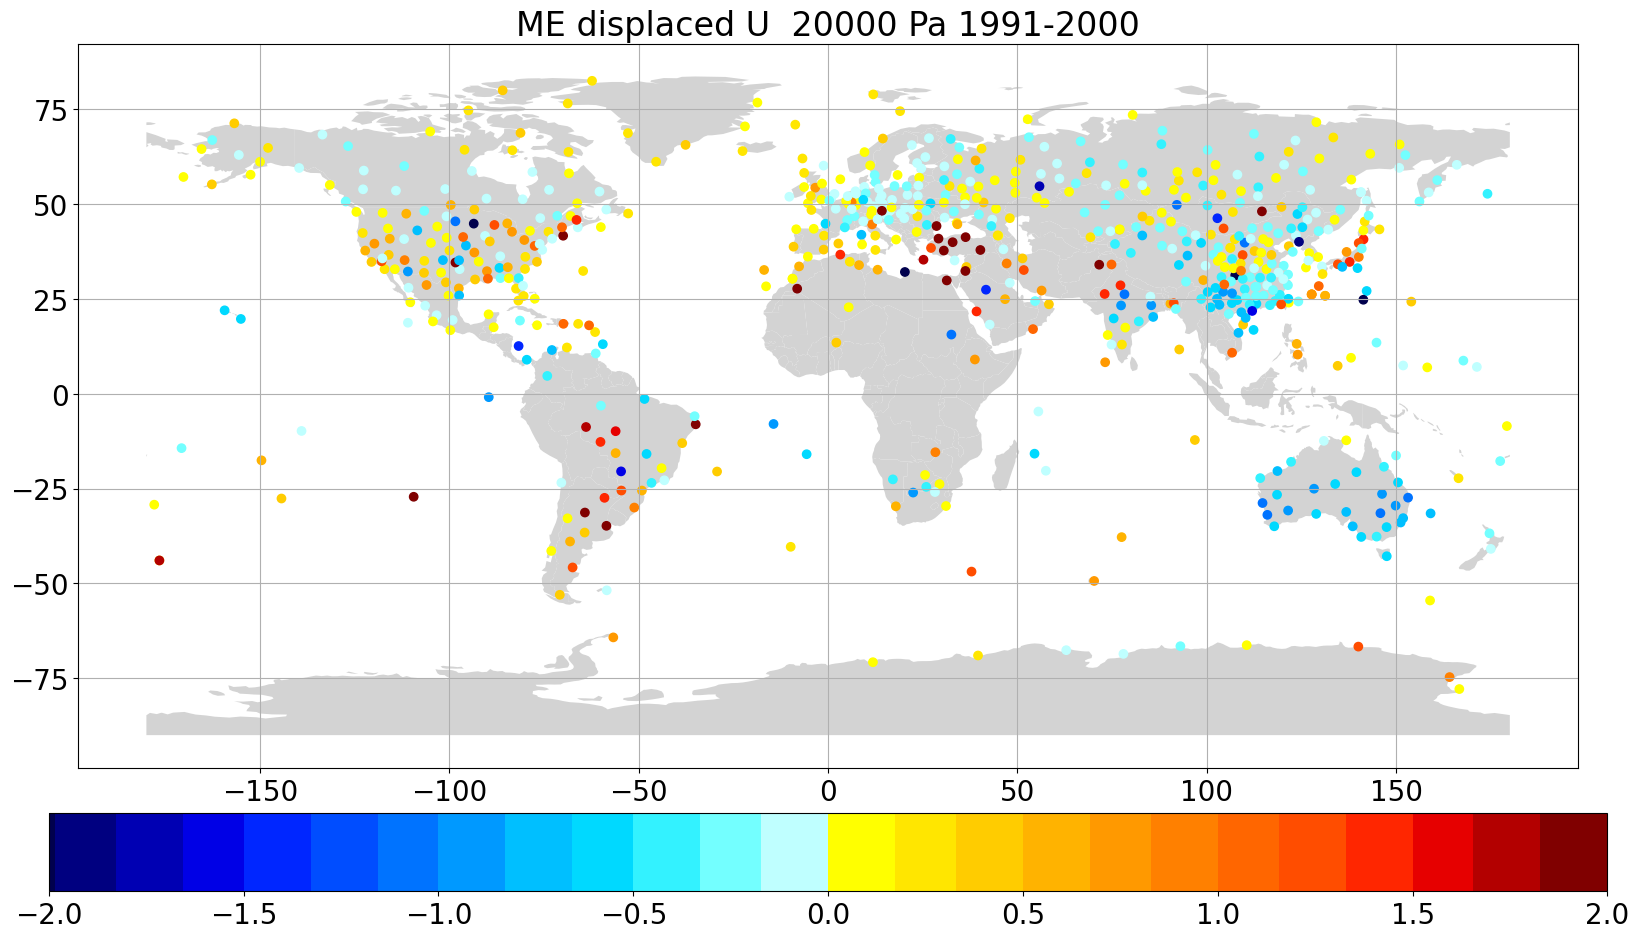

In [20]:
var = 'U'
year = '1991-2000'
files = glob.glob('./pre_calculated_rms data/era5_u_fc_*_rmse_data.p')
# diffs, difflist = plot_year_me(files, str(year), param='disp')


diffarray = np.array(i_difflist_di['./pre_calculated_rms data/era5_u_fc_2000_rmse_data.p'])

# outlier_cleaned_data = np.empty_like(diffarray)
outlier_cleaned_dict = copy.deepcopy(diffs_di)
limit = [1,99]
for i in range(np.shape(diffarray)[-1]):
    data = diffarray[:, i]
    outlier_drop = np.nanpercentile(data, limit)
    data[data < outlier_drop[0]] = np.nan
    data[data > outlier_drop[1]] = np.nan
    # outlier_cleaned_data[:, i] = data
    
    for j in diffs_di:
        if (diffs_di[j][i] < outlier_drop[0]) or (diffs_di[j][i] > outlier_drop[1]):
            outlier_cleaned_dict[j][i] = np.nan
            
    
# stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
# fig, ax = maplt.subplots(5, 3, figsize = (15,15))
# fig.tight_layout()
# x = 0
# y = 0
# for i in range(0,15,1):
#     if y == 3:
#         x += 1
#         y = 0
#     ax[x][y].hist(outlier_cleaned_data[:, i], 50, range=(-1,1))
#     ax[x][y].set_title(str(stdplevs[i]) + ' Pa')
#     ax[x][y].grid()
    
#     y += 1
# # fig.show()
# fig.savefig("ME_displaced_"+var+"_hist_" + str(year) + '.png')


# stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
# fig, ax = maplt.subplots(5, 3, figsize = (15,15))
# fig.tight_layout()
# x = 0
# y = 0
# for i in range(0,15,1):
#     if y == 3:
#         x += 1
#         y = 0
#     ax[x][y].hist(outlier_cleaned_data[:, i], 2, range=(-1,1))
#     ax[x][y].set_title(str(stdplevs[i]) + ' Pa')
#     ax[x][y].grid()
#     y += 1
# # fig.show()
# fig.savefig("ME_displaced_"+var+"_binary_hist_" + str(year) + '.png')


def plt_world_map(lla, pl ,year):    
    fig, ax = plt.subplots(figsize=(18,10))# plot map on axis
    countries = gpd.read_file(  
    #      gpd.datasets.get_path("naturalearth_lowres"))countries[countries["name"] == "Australia"].plot(color="lightgrey",
    #                                                  ax=ax)# parse dates for plot's title
        gpd.datasets.get_path("naturalearth_lowres")).plot(color="lightgrey", ax=ax)# parse dates for plot's title
    plt1 = ax.scatter(x=lla["longitude"], y=lla["latitude"],
                c=lla["diff"], 
                cmap= cmnew,
                vmin=-2, vmax=2, #edgecolor='k',
              )
    ax.set_title("ME displaced "+var+" " + ' ' + str(pl) + ' Pa ' + str(year))
    ax.grid(b=True, alpha=1)
    plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.show()
    fig.savefig("ME_displaced_"+var+"_" + str(pl) + '_Pa_' + str(year) + '.png')
    plt.close()
    
with open('/users/staff/uvoggenberger/scratch/hug/config/active.json') as fp:
    active = json.load(fp)
stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
diff_plot_input = {}
for p in range(len(stdplevs)):
    diff_plot_input[stdplevs[p]] = [[],[],[]]
    for i in diffs_di:
        for a in active:
            if i in a:
                if not np.isnan(diffs_di[i][p]):
                    diff_plot_input[stdplevs[p]][0].append(outlier_cleaned_dict[i][p])
                    diff_plot_input[stdplevs[p]][1].append(active[a][2])
                    diff_plot_input[stdplevs[p]][2].append(active[a][3])
                break

stdplevs = [20000]#[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
for i in np.flip(stdplevs):
    df = pd.DataFrame(np.transpose(np.array(diff_plot_input[i])), columns =['diff', 'latitude', 'longitude'])
    plt_world_map(df, i, year)

# UNDISPLACED

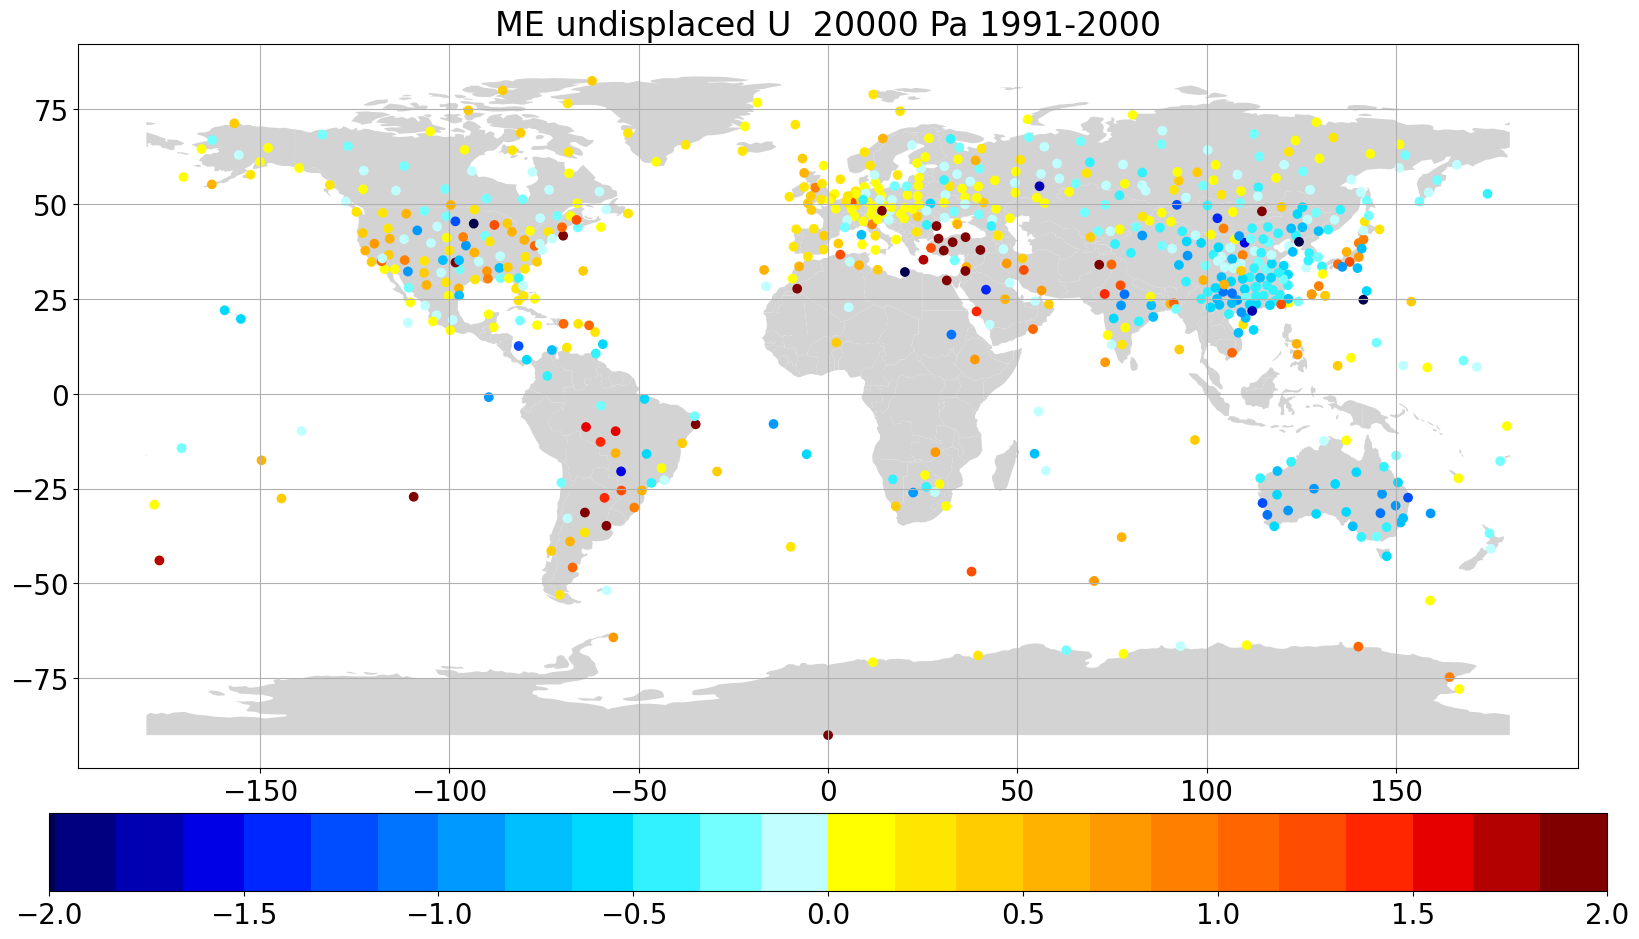

In [21]:
var = 'U'
year = '1991-2000'
files = glob.glob('./pre_calculated_rms data/era5_u_fc_*_rmse_data.p')
# diffs, difflist = plot_year_me(files, str(year), param='undisp')


diffarray = np.array(i_difflist_ud['./pre_calculated_rms data/era5_u_fc_2000_rmse_data.p'])

# outlier_cleaned_data = np.empty_like(diffarray)
outlier_cleaned_dict = copy.deepcopy(diffs_ud)
limit = [1,99]
for i in range(np.shape(diffarray)[-1]):
    data = diffarray[:, i]
    outlier_drop = np.nanpercentile(data, limit)
    data[data < outlier_drop[0]] = np.nan
    data[data > outlier_drop[1]] = np.nan
    # outlier_cleaned_data[:, i] = data
    
    for j in diffs_ud:
        if (diffs_ud[j][i] < outlier_drop[0]) or (diffs_ud[j][i] > outlier_drop[1]):
            outlier_cleaned_dict[j][i] = np.nan
            
    
# stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
# fig, ax = maplt.subplots(5, 3, figsize = (15,15))
# fig.tight_layout()
# x = 0
# y = 0
# for i in range(0,15,1):
#     if y == 3:
#         x += 1
#         y = 0
#     ax[x][y].hist(outlier_cleaned_data[:, i], 50, range=(-1,1))
#     ax[x][y].set_title(str(stdplevs[i]) + ' Pa')
#     ax[x][y].grid()
    
#     y += 1
# # fig.show()
# fig.savefig("ME_undisplaced_"+var+"_hist_" + str(year) + '.png')


# stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
# fig, ax = maplt.subplots(5, 3, figsize = (15,15))
# fig.tight_layout()
# x = 0
# y = 0
# for i in range(0,15,1):
#     if y == 3:
#         x += 1
#         y = 0
#     ax[x][y].hist(outlier_cleaned_data[:, i], 2, range=(-1,1))
#     ax[x][y].set_title(str(stdplevs[i]) + ' Pa')
#     ax[x][y].grid()
#     y += 1
# # fig.show()
# fig.savefig("ME_undisplaced_"+var+"_binary_hist_" + str(year) + '.png')


def plt_world_map(lla, pl ,year):    
    fig, ax = plt.subplots(figsize=(18,10))# plot map on axis
    countries = gpd.read_file(  
    #      gpd.datasets.get_path("naturalearth_lowres"))countries[countries["name"] == "Australia"].plot(color="lightgrey",
    #                                                  ax=ax)# parse dates for plot's title
        gpd.datasets.get_path("naturalearth_lowres")).plot(color="lightgrey", ax=ax)# parse dates for plot's title
    plt1 = ax.scatter(x=lla["longitude"], y=lla["latitude"],
                c=lla["diff"], 
                cmap= cmnew,
                vmin=-2, vmax=2, #edgecolor='k',
              )
    ax.set_title("ME undisplaced "+var+" " + ' ' + str(pl) + ' Pa ' + str(year))
    ax.grid(b=True, alpha=1)
    plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.show()
    fig.savefig("ME_undisplaced_"+var+"_" + str(pl) + '_Pa_' + str(year) + '.png')
    plt.close()
    
with open('/users/staff/uvoggenberger/scratch/hug/config/active.json') as fp:
    active = json.load(fp)
stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
diff_plot_input = {}
for p in range(len(stdplevs)):
    diff_plot_input[stdplevs[p]] = [[],[],[]]
    for i in diffs_ud:
        for a in active:
            if i in a:
                if not np.isnan(diffs_ud[i][p]):
                    diff_plot_input[stdplevs[p]][0].append(outlier_cleaned_dict[i][p])
                    diff_plot_input[stdplevs[p]][1].append(active[a][2])
                    diff_plot_input[stdplevs[p]][2].append(active[a][3])
                break

stdplevs = [20000]#[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
for i in np.flip(stdplevs):
    df = pd.DataFrame(np.transpose(np.array(diff_plot_input[i])), columns =['diff', 'latitude', 'longitude'])
    plt_world_map(df, i, year)